# Never gonna give you up
# Never gonna DRAG you down

Howdy folks. Today we'll be quantum mechanic.

In [2]:
# First we set up some basic dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import qiskit as qis
import qiskit.pulse as qisp
from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit import IBMQ, schedule
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.compiler.assembler import MeasLevel, MeasReturnType
from qiskit.tools.monitor import job_monitor

if not IBMQ.active_account():
    IBMQ.load_account()
    
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibm_oslo')
backend_defaults = backend.defaults()
backend_properties = backend.properties()

In [3]:
scale_factor = 1e-7
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    job_results = job.result()  # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average:  # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
            print('here')
        else:  # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
            print(i, end='\r')
    return result_data


def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require
    durations which are multiples of 16 samples.
    """
    return int(num + 8) - (int(num + 8) % 16)

In [4]:
qubit = 0

GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

f01 = backend.configuration().hamiltonian['vars'][f'wq{qubit}']/(2*np.pi)
anhar = (backend.properties().qubits[qubit][3].value)*1e9 # anhar in Hz => convert to GHz
f12 = f01 + anhar
x_sigma = 80
x_duration = 320
x01_amp = 0.07513041041956571
x12_amp = 0.07077182615095635

# Discriminator

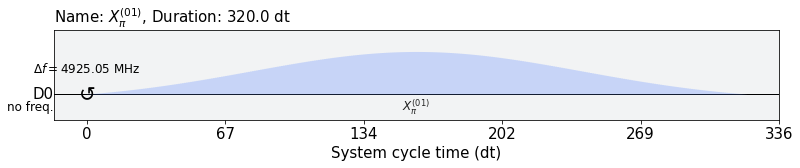

In [64]:
with qisp.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(01)}$') as inst_xpi01:
    drive_chan = qisp.drive_channel(qubit)
    qisp.set_frequency(f01, drive_chan)
    qisp.play(qisp.Gaussian(duration=x_duration,
                            amp=x01_amp,
                            sigma=x_sigma,
                            name=r'$X_{\pi}^{(01)}$'), drive_chan)
xpi01 = Gate('xp01', 1, [])
inst_xpi01.draw()

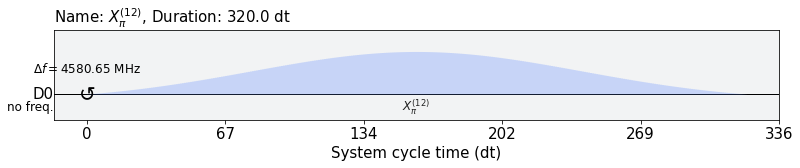

In [65]:
with qisp.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(12)}$') as inst_xpi12:
    drive_chan = qisp.drive_channel(qubit)
    qisp.set_frequency(f12, drive_chan)
    qisp.play(qisp.Gaussian(duration=x_duration,
                              amp=x12_amp,
                              sigma=x_sigma,
                              name=r'$X_{\pi}^{(12)}$'), drive_chan)

xpi12 = Gate('xp12', 1, [])
inst_xpi12.draw()

In [66]:
# 0 state
ground_circs = QuantumCircuit(1, 1)
ground_circs.measure(0, 0)

# 1 state
one_circs = QuantumCircuit(1, 1)
one_circs.append(xpi01, [0])
one_circs.measure(0, 0)
one_circs.add_calibration(xpi01, (0,), inst_xpi01, [])

# 2 state
two_circs = QuantumCircuit(1, 1)
two_circs.append(xpi01, [0])
two_circs.append(xpi12, [0])
two_circs.measure(0, 0)
two_circs.add_calibration(xpi12, (0,), inst_xpi12, [])
two_circs.add_calibration(xpi01, (0,), inst_xpi01, [])

discriminator_circs = [ground_circs, one_circs, two_circs]

In [67]:

discriminator_job = backend.run(discriminator_circs,
                       meas_level=1,
                       meas_return='single',
                       shots=20000)

In [68]:
discriminator_job.job_id()

'6358f281227bc17b6c7e6206'

# Discriminator job
'6347db674a53e849a5e39285'
'6358f281227bc17b6c7e6206

In [13]:
discriminator_job = backend.retrieve_job('6358f281227bc17b6c7e6206')

In [14]:
discriminator_data = get_job_data(discriminator_job, average=False)
zero_data = discriminator_data[0]
one_data = discriminator_data[1]
two_data = discriminator_data[2]


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i] = [np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped


# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)
two_data_reshaped = reshape_complex_vec(two_data)

IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
print(IQ_012_data.shape)  # verify IQ data shape

NUM_SHOTS = 20000

# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(NUM_SHOTS)  # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2 * np.ones(NUM_SHOTS)))
print(len(state_012))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)

# Set up the LDA
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)


def count(job, discriminator):
    print('retrieving data from', job.job_id())
    data = get_job_data(job, average=False)
    print('data is retrieved from', job.job_id())
    sched_data = []
    for i in range(len(data)):
        sched_data.append(reshape_complex_vec(data[i]))
    discrim_data = []
    for j in range(len(sched_data)):
        discrim_data.append(discriminator.predict(sched_data[j]))
        print('predicting', j, end='\r')
    final_result = []
    for k in range(len(discrim_data)):
        result = {'0': 0, '1': 0, '2': 0}
        for l in range(len(discrim_data[k])):
            if discrim_data[k][l] == 0.0:
                result['0'] += 1
            elif discrim_data[k][l] == 1.0:
                result['1'] += 1
            elif discrim_data[k][l] == 2.0:
                result['2'] += 1
            else:
                print('Unexpected behavior')
        final_result.append(result)
    return final_result


(60000, 2)
60000


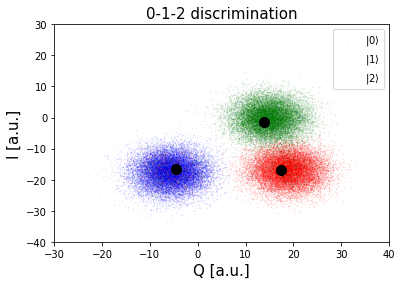

In [10]:
def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    alpha = 0.2
    size = 0.05
    plt.scatter(np.real(zero_data), np.imag(zero_data),
                s=size, cmap='viridis', c='blue', alpha=alpha, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data),
                s=size, cmap='viridis', c='red', alpha=alpha, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data),
                s=size, cmap='viridis', c='green', alpha=alpha, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    mean_alpha = 1
    mean_size = 100
    plt.scatter(np.real(mean_zero), np.imag(mean_zero),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_one), np.imag(mean_one),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_two), np.imag(mean_two),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

def separatrixPlot(lda, x_min, x_max, y_min, y_max, shots):
    nx, ny = shots, shots

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='black')
x_min = -30
x_max = 40
y_min = -40
y_max = 30
IQ_012_plot(x_min, x_max, y_min, y_max)
# separatrixPlot(LDA_012, x_min, x_max, y_min, y_max, NUM_SHOTS)


In [18]:
import numpy.linalg as la
discr_data = count(discriminator_job, LDA_012)
confusion_mat = [[discr_data[i]['0'] / 20000, discr_data[i]['1'] / 20000, discr_data[i]['2'] / 20000] for i in
                 range(np.shape(discr_data)[0])]
mitigation_mat = la.inv(confusion_mat)
confusion_mat

retrieving data from 6358f281227bc17b6c7e6206
data is retrieved from 6358f281227bc17b6c7e6206


[[0.89695, 0.0207, 0.08235],
 [0.05945, 0.8784, 0.06215],
 [0.0569, 0.07125, 0.87185]]

# DRAG calibration

In [9]:
drive_betas = np.linspace(-25, 75, 100)
def exp_drag_circs(n, drive_betas):
    drive_beta = Parameter('drive_beta')
    with qisp.build(backend=backend, default_alignment='sequential') as XX_sched:
        qisp.set_frequency(f12, qisp.drive_channel(0))
        qisp.play(qisp.Drag(duration=x_duration,
                            amp=x12_amp,
                            sigma=x_sigma,
                            beta=drive_beta), qisp.drive_channel(0))
        qisp.shift_phase(-np.pi, qisp.drive_channel(0))
        qisp.play(qisp.Drag(duration=x_duration,
                            amp=x12_amp,
                            sigma=x_sigma,
                            beta=drive_beta), qisp.drive_channel(0))
        qisp.shift_phase(-np.pi, qisp.drive_channel(0))

    XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
    qc_DRAG = QuantumCircuit(1, 1)
    qc_DRAG.x(0)
    i = 0
    while i < n:
        qc_DRAG.append(XX, [0])
        i += 1
    qc_DRAG.measure(0, 0)
    qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
    return [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]


# single meas_level = 1

In [32]:
drag_job_single = backend.run(exp_drag_circs(1, np.linspace(-100, 100, 100)),
                              meas_level=1,
                              meas_return='single',
                              shots=20000)
drag_job_single.job_id()

'6350bf8c708bc4d2acf01fb5'

In [ ]:
drag_job_single = backend.retrieve_job('6350bf8c708bc4d2acf01fb5')
drag_values = count(drag_job_single, LDA_012)
one_population = [val['1']/20000 for val in drag_values]
plt.scatter(drive_betas, one_population, marker='o', linestyle='-', color= 'red')

retrieving data from 6350bf8c708bc4d2acf01fb5


In [ ]:
drag_job_single = []
drag_job_single_id = []
for i in range(5):
    drag_job = backend.run(exp_drag_circs(2*i + 3, drive_betas),
                               meas_level=1,
                               meas_return='single',
                               shots=20000)
    drag_job_single.append(drag_job)
    drag_job_single_id.append(drag_job.job_id())
drag_job_single_id

In [20]:
def get_population(job_id, discriminator):
    drag_job = backend.retrieve_job(job_id)
    print('getting population from', job_id)
    drag_values = count(drag_job, discriminator)
    return [[val['0']/20000, val['1']/20000, val['2']/20000] for val in drag_values]

In [29]:
# job_ids = ['634d129d65bf29eba1a757be', '634d4f61e1fa1c1a11de3e9d', '634d4f694a53e8ceaee39d8d']
job_ids = ['634e93c8d85187394ffb637e',
           '634e93cb708bc4e8c0f01749',
           '634e93ce65bf291e66a75c42',
           '634e93d2e1fa1c8992de41cb',
           '634e93d54a53e8725ce3a0a3']
colors = ['red', 'blue', 'green']
one_population = [get_population(id, LDA_012)[1] for id in job_ids]

retrieving 634e93c8d85187394ffb637e
getting one population from 634e93c8d85187394ffb637e
retrieving data from 634e93c8d85187394ffb637e
data is retrieved from 634e93c8d85187394ffb637e
retrieving 634e93cb708bc4e8c0f01749
getting one population from 634e93cb708bc4e8c0f01749
retrieving data from 634e93cb708bc4e8c0f01749
data is retrieved from 634e93cb708bc4e8c0f01749
retrieving 634e93ce65bf291e66a75c42
getting one population from 634e93ce65bf291e66a75c42
retrieving data from 634e93ce65bf291e66a75c42
data is retrieved from 634e93ce65bf291e66a75c42
retrieving 634e93d2e1fa1c8992de41cb
getting one population from 634e93d2e1fa1c8992de41cb
retrieving data from 634e93d2e1fa1c8992de41cb
data is retrieved from 634e93d2e1fa1c8992de41cb
retrieving 634e93d54a53e8725ce3a0a3
getting one population from 634e93d54a53e8725ce3a0a3
retrieving data from 634e93d54a53e8725ce3a0a3
data is retrieved from 634e93d54a53e8725ce3a0a3
retrieving 634e93c8d85187394ffb637e
getting one population from 634e93c8d85187394ffb6

Text(0, 0.5, '$P_{|1\\rangle}$')

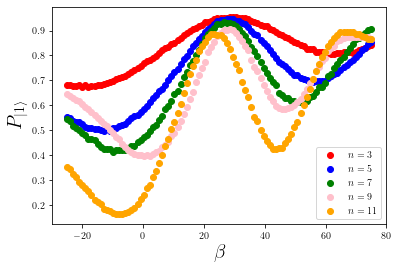

In [26]:
colors = ['red', 'blue', 'green', 'pink', 'orange']
plt.rcParams['text.usetex'] = True
for i in range(5):
    plt.scatter(drive_betas, one_population[i], marker='o', linestyle='-', color= colors[i])
plt.legend([f'$n = {2*i + 3}$' for i in range(5)], fontsize = 10)
# plt.xlim(20, 40)
plt.xlabel('$\\beta$', fontsize = 20)
plt.ylabel('$P_{|1\\rangle}$', fontsize = 20)

amplitude = (0.172029663684108+0j), beta = 0.22876378193841831, duration = 160, sigma = 40


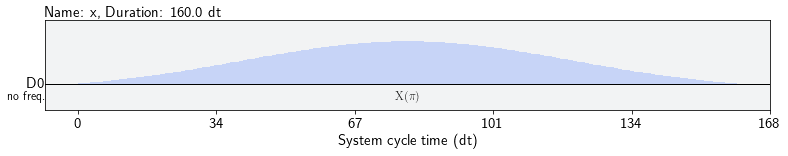

In [30]:
x_def = backend.defaults().instruction_schedule_map.get('x',qubits = [0])
x_def_pulse = x_def.instructions[0][1].pulse
print(f"amplitude = {x_def_pulse.amp}, beta = {x_def_pulse.beta}, duration = {x_def.duration}, sigma = {x_def_pulse.sigma}")
x_def.draw()

# X12 DRAG Schedule

In [4]:
beta01 = 0.1401401401401401

In [6]:
with qisp.build(backend=backend, default_alignment='sequential') as X01_drag_sched:
    qisp.set_frequency(f01, qisp.drive_channel(0))
    qisp.play(qisp.Drag(duration=x_duration,
                        amp=x01_amp,
                        sigma=x_sigma,
                        beta=beta01), qisp.drive_channel(0))

In [17]:
drive_betas = np.linspace(-100, -1, 100)
drive_beta = Parameter('drive_beta')
with qisp.build(backend=backend, default_alignment='sequential') as X12_drag_sched:
    qisp.set_frequency(f12, qisp.drive_channel(0))
    qisp.play(qisp.Drag(duration=x_duration,
                        amp=x12_amp,
                        sigma=x_sigma,
                        beta=drive_beta), qisp.drive_channel(0))
qc_DRAG = QuantumCircuit(1, 1)
X01_drag = Gate("$X^{01}_\pi$", 1, [])
X12_drag = Gate("$X^{12}_\pi$", 1, [drive_beta])
qc_DRAG.append(X01_drag, [0])
qc_DRAG.append(X12_drag, [0])
qc_DRAG.measure(0, 0)
qc_DRAG.add_calibration(X01_drag, (0,), X01_drag_sched)
qc_DRAG.add_calibration(X12_drag, (0,), X12_drag_sched, [drive_beta])

X12_drag_circs = [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]

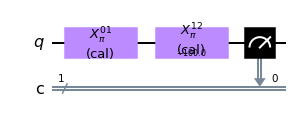

In [43]:
X12_drag_circs[0].draw(output='mpl')

In [18]:
X12_drag_job = backend.run(X12_drag_circs,
                              meas_level=1,
                              meas_return='single',
                              shots=20000)
X12_drag_job.job_id()

'6357ddfa3bcead76595ea906'

## X12 DRAG results
(0, 99): '6357ddba3bceada9e35ea903'
(-100, -1): '6357ddfa3bcead76595ea906'



In [37]:
ids = ['6357ddfa3bcead76595ea906','6357ddba3bceada9e35ea903']
population = []
for id in ids:
    for pop in get_population(id, LDA_012):
        population.append(pop)

retrieving 6357ddfa3bcead76595ea906
getting population from 6357ddfa3bcead76595ea906
retrieving data from 6357ddfa3bcead76595ea906
data is retrieved from 6357ddfa3bcead76595ea906
retrieving 6357ddba3bceada9e35ea903
getting population from 6357ddba3bceada9e35ea903
retrieving data from 6357ddba3bceada9e35ea903
data is retrieved from 6357ddba3bceada9e35ea903


In [38]:
len(population)

200

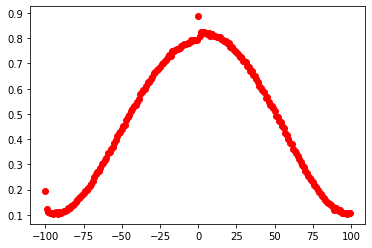

In [42]:
plt.scatter(np.linspace(-100, 99, 200), [pop[2] for pop in population], marker='o', linestyle='-', color= 'red')

# Rabi 01

In [21]:
population = []
for pop in get_population('635a778e6756f96a08ef497f', LDA_012):
    population.append(pop)

getting population from 635a778e6756f96a08ef497f
retrieving data from 635a778e6756f96a08ef497f
data is retrieved from 635a778e6756f96a08ef497f


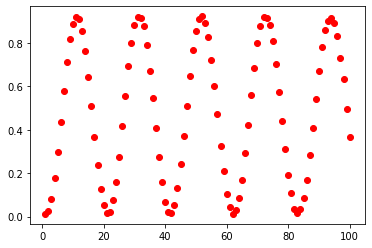

In [22]:
plt.scatter(np.linspace(1, 100, 100), [pop[1] for pop in population], marker='o', linestyle='-', color= 'red')

In [ ]:
num_rabi_points = 100

drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

params = curve_fit(drive_amps, population[1], lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B), [])

## IBM default X result

In [22]:
X_circs = []
for i in range(100):
    qc_X = QuantumCircuit(1, 1)
    X01_drag = Gate("$X^{01}_\pi$", 1, [])
    qc_X.add_calibration(X01_drag, (0,), X01_drag_sched)
    qc_X.append(X01_drag, [0])
    qc_X.measure(0, 0)
    X_circs.append(qc_X)

In [23]:
X_job = backend.run(X_circs,
                           meas_level=1,
                           meas_return='single',
                           shots=20000)
X_job.job_id()

'6357dec51ff364fb82749621'

In [17]:
population = get_population('6357a8a2333aebed5989e9ae', LDA_012)

getting population from 6357a8a2333aebed5989e9ae
retrieving data from 6357a8a2333aebed5989e9ae
data is retrieved from 6357a8a2333aebed5989e9ae


(0.0, 1.0)

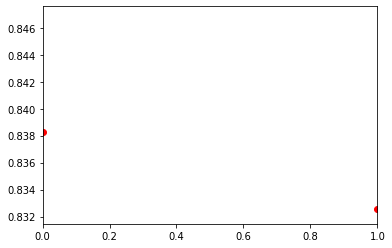

In [51]:
plt.scatter(range(100), [pop[1] for pop in population], marker='o', linestyle='-', color= 'red')
plt.ylim(0,1)

# SX exp

In [12]:
with qisp.build(backend=backend, default_alignment='sequential') as SX_sched:
    qisp.set_frequency(drive_freq, qisp.drive_channel(0))
    qisp.play(qisp.Drag(duration=x_duration,
                        amp=x_amp/2,
                        sigma=x_sigma,
                        beta=beta_optimum), qisp.drive_channel(0))


In [13]:
SX_circs = []
for i in range(100):
    qc_SX = QuantumCircuit(1, 1)
    SX = Gate("$SX$", 1, [])
    qc_SX.add_calibration(SX, (0,), SX_sched, [])
    qc_SX.append(SX, [0])
    for j in range(i):
        qc_SX.append(SX, [0])
    qc_SX.measure(qubit, 0)
    SX_circs.append(qc_SX)

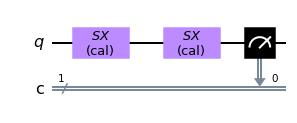

In [344]:
SX_circs[1].draw(output='mpl')

In [345]:
len(SX_circs)

100

In [346]:
SX_job = backend.run(SX_circs,
                    meas_level=2,
                    meas_return='single',
                    shots=2**14)
SX_job.job_id()

'633f8983e212b028d4beef0c'

In [117]:
job_monitor(SX_job)

Job Status: job is queued (156)

KeyboardInterrupt: 

# SX job
633ea125feb64c920ea00369: -1.3013013013013008
633f8983e212b028d4beef0c: -0.6206206206206204


In [14]:
SX_job = backend.retrieve_job('633f8983e212b028d4beef0c')

In [15]:
SX_results = SX_job.result().get_counts()

In [16]:
zero_population = [SX_results[i]['0']/2**14 for i in range(100)]
len(zero_population)

100

In [162]:
def SX_theory(val, epsilon):
    # return [1/2 + 1/2*np.cos(n*(np.pi/2 + epsilon)) for n in val]
    return [np.cos(n*(np.pi/2 + epsilon)/2)**2 for n in val]


[0.04397003]


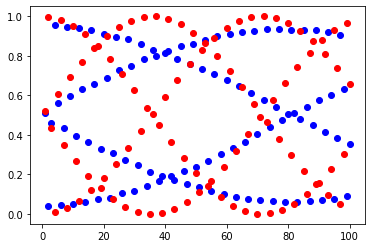

In [159]:
exp_num = [i + 1  for i in range(100)]

SX_params, SX_fit = fit_function(range(100),
                                       zero_population,
                                       SX_theory,
                                       [0.02])
print(SX_params)
plt.scatter(exp_num, zero_population, marker='o', linestyle='-', color='blue')
# plt.plot(range(100), SX_theory(range(100), SX_params), color='red')
# plt.xlim([0, 20])
plt.scatter(exp_num, SX_theory(exp_num, SX_params), color='red')

(0.0, 20.0)

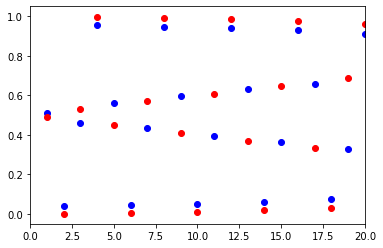

In [163]:
plt.scatter(exp_num, zero_population, marker='o', linestyle='-', color='blue')
plt.scatter(exp_num, SX_theory(exp_num, 0.02), color='red')
plt.xlim(0, 20)

In [18]:
SX_odd_circs = []
for i in range(100):
    qc_SX = QuantumCircuit(1, 1)
    SX = Gate("$SX$", 1, [])
    qc_SX.add_calibration(SX, (0,), SX_sched, [])
    qc_SX.append(SX, [0])
    for j in range(i):
        qc_SX.append(SX, [0])
        qc_SX.append(SX, [0])
    qc_SX.measure(qubit, 0)
    SX_odd_circs.append(qc_SX)


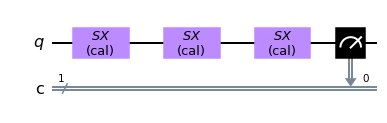

In [351]:
SX_odd_circs[1].draw(output='mpl')

In [266]:
SX_odd_job = backend.run(SX_odd_circs,
                     meas_level=2,
                     meas_return='single',
                     shots=2**14)
SX_odd_job.job_id()

'633ebe58338f42c077b76051'

In [19]:
SX_odd_job = backend.retrieve_job('633ebe58338f42c077b76051')

In [21]:
SX_odd_results = SX_odd_job.result().get_counts()
zero_population_odd = [SX_odd_results[i]['0']/2**14 for i in range(100)]

In [151]:
def SX_odd_theory(val, A, B, epsilon):
    # return [1/2 + 1/2*(-1)**n*np.cos(np.pi/2 + (2*n + 1)*epsilon) for n in val] #sheldon 2015
    return [A + B*np.cos((2*n + 1)*(epsilon + np.pi/2)) for n in val]
    # return [np.cos((epsilon + np.pi/2)*(n + 1/2))**2 for n in val]

In [166]:
num_fit = 78
exp_num = [i + 1  for i in range(100)]
SX_odd_params = curve_fit(SX_odd_theory, exp_num[:num_fit], zero_population_odd[:num_fit], p0 = [1/2, 1/2, 0.02], maxfev=5000)[0]
print(SX_odd_params)
residuals = [zero_population_odd[i] - SX_odd_theory(exp_num[i], *SX_odd_params) for i in range(num_fit)]
ss_res = np.sum(residuals**2)
ss_tot = np.sum((zero_population_odd[:num_fit]-np.mean(zero_population_odd[:num_fit]))**2)
r_squared = 1 - (ss_res / ss_tot)
print('r-squared =', r_squared)

plt.scatter(exp_num[:num_fit], zero_population_odd[:num_fit], marker='o', linestyle='-', color='blue')
# plt.plot(range(75), zero_population_odd[:75], marker='o', linestyle='-', color='blue')
# plt.xlim(0,10)

plt.scatter(exp_num[:num_fit], SX_odd_theory(range(num_fit), *SX_odd_params), color='red')

[0.50823087 0.4525394  0.02019534]


TypeError: 'int' object is not iterable

(0.0, 10.0)

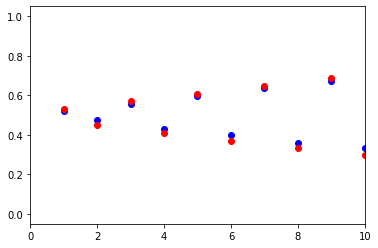

In [143]:
plt.scatter(exp_num[:75], zero_population_odd[:75], marker='o', linestyle='-', color='blue')
plt.scatter(exp_num[:75], SX_odd_theory(exp_num[:75], 0.02), color='red')
plt.xlim(0, 10)